# Erstes Quantenchemieprogramm
## Hartreesche SCF-Methode für Helium

Für das Heliumatom im Hartree-Modell gibt es genau ein besetztes räumliches Orbital
$\phi$, das von zwei Elektronen besetzt wird. Praktisch löst man das nichtlineare Eigenwertproblem, indem man mit einem Startvektor $\mathbf c^{(0)}$ beginnt, daraus eine Hartree-Matrix $\mathbf F[\mathbf c^{(0)}]$ konstruiert, das verallgemeinerte Eigenwertproblem löst, den Eigenvektor mit niedrigstem Eigenwert als neues $\mathbf c^{(1)}$ verwendet und diesen selbstkonsistenten Zyklus fortsetzt, bis sich $\mathbf c$ (und damit $\phi$ und $V_H$) nicht mehr ändert. Wir schreiben nun unser allererstes Quantenchemie-Programm zur Lösung der Hartree-Gleichung für Helium.

SCF-Iteration   0   E = -2.2112633618
SCF-Iteration   1   E = -3.1048216670
SCF-Iteration   2   E = -2.7963403527
SCF-Iteration   3   E = -2.8798231903
SCF-Iteration   4   E = -2.8546222368
SCF-Iteration   5   E = -2.8619859849
SCF-Iteration   6   E = -2.8598139171
SCF-Iteration   7   E = -2.8604528015
SCF-Iteration   8   E = -2.8602647275
SCF-Iteration   9   E = -2.8603200794
SCF-Iteration  10   E = -2.8603037875
SCF-Iteration  11   E = -2.8603085821
SCF-Iteration  12   E = -2.8603071715


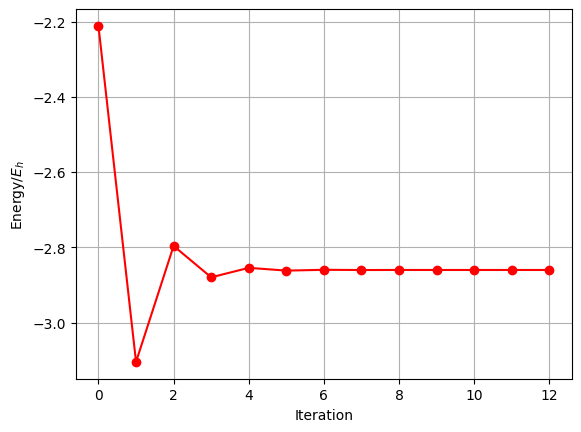

In [7]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def Ng(a): 
    return (2*a/np.pi)**0.75

def Sij(a,b):
    return Ng(a)*Ng(b)*(np.pi/(a+b))**1.5

def Tij(a,b):
    return Ng(a)*Ng(b)*3*a*b/(a+b)*(np.pi/(a+b))**1.5

def Vij(a,b, Z=2.0):
    return Ng(a)*Ng(b)*(-2*Z)*np.pi/(a+b)

def Gijkl(a,b,c,d):
    A = a+b
    B = c+d
    return Ng(a)*Ng(b)*Ng(c)*Ng(d) * 2*np.pi**2.5/(A*B*np.sqrt(A+B))

exps = np.array([0.05*(4.**n) for n in range(15)])
ndim = len(exps)

# Calculate one-electron integrals
A,B = np.meshgrid(exps,exps,indexing='ij')
S = Sij(A,B)
T = Tij(A,B)
V = Vij(A,B)
h = T + V
# Calculate two-electron integrals
A,B,C,D = np.meshgrid(exps,exps,exps,exps,indexing='ij')
G = Gijkl(A,B,C,D)

# Initial guess (starting orbital)
c = np.ones(ndim)
c /= np.sqrt(c.T @ S @ c)

#SCF loop 
Energy_list = []
max_iter = 20
for it in range(max_iter):
    
    J = np.einsum("mnls,l,s->mn", G, c, c)
    F = h + J

    epsilon, Cmat = eigh(F, S)
    c_new = Cmat[:, epsilon.argmin()]
    c_new /= np.sqrt(c_new.T @ S @ c_new)
    
    # total Hartree energy
    E = 2*(c_new.T @ h @ c_new) + (c_new.T @ J @ c_new)
    Energy_list.append(E)
    print(f"SCF-Iteration  {it:2d}   E = {E:.10f}")
    if np.linalg.norm(c_new - c) < 1e-6:
        break
    c = c_new

# Plot convergence
plt.plot(Energy_list, marker='o', color = "red")
plt.xlabel("Iteration")
plt.ylabel(f"Energy/$E_h$")
plt.grid(True)
plt.show()


In [8]:
## Ergänzung: Lösung der Gauss-Integrale mit Sympy

import sympy as sp
from sympy import oo

alpha, beta = sp.symbols('alpha beta', real = True, positive = True)
r = sp.symbols('r', real = True, positive = True)

psi_mu = sp.exp(-alpha * r**2)
psi_nu = sp.exp(-beta * r**2)

S = sp.integrate(4*sp.pi**2*psi_mu*psi_nu*r**2, (r,0,oo))

S = S.simplify()
print(f"Overlap integral = {S}")

N = sp.integrate(4*sp.pi**2*psi_mu*psi_mu*r**2, (r,0,oo))
print(f"Norm = {(1/sp.sqrt(N)).simplify()}")

def T(psi):
    return -(psi.diff(r,2) + (2/r)*psi.diff(r))/2
T = sp.integrate(4*sp.pi*r**2*psi_mu*T(psi_nu), (r,0,oo)).simplify()
print(f"Kinetic energy = {T}")

def V(psi):
    return (-2/r)*psi
V = sp.integrate(4*sp.pi**2*r**2*psi_mu*V(psi_nu), (r,0,oo)).simplify()
print(f"Nuclear attraction = {V}")

r1, r2, r12 = sp.symbols('r1 r2 r12', positive=True)
alpha, beta, gamma, delta = sp.symbols('alpha beta gamma delta', positive=True)
p, q = sp.symbols('p q', real = True, positive = True)
psi1 = sp.exp(-p*r1**2)
psi2 = sp.exp(-q*r2**2)

integrand = r1*r2*(psi1)*(psi2)

# Region A: 0 < r2 < r1  ⇒  r12 ∈ [r1 - r2, r1 + r2]
I1 = sp.integrate(integrand, (r12, r1 - r2, r1 + r2),
                               (r2, 0, r1),
                               (r1, 0, oo))

# Region B: r1 < r2 < ∞  ⇒  r12 ∈ [r2 - r1, r1 + r2]
I2 = sp.integrate(integrand, (r12, r2 - r1, r1 + r2),
                               (r2, r1, oo),
                               (r1, 0, oo))

I = 8*sp.pi**2*(I1 + I2)
I_simplified = sp.simplify(I)
eri = I_simplified.subs({p: alpha+beta, q: gamma+delta})
print(f"Electron repulsion = {eri}")

Overlap integral = pi**(5/2)/(alpha + beta)**(3/2)
Norm = 2**(3/4)*alpha**(3/4)/pi**(5/4)
Kinetic energy = 3*pi**(3/2)*alpha*beta/(alpha + beta)**(5/2)
Nuclear attraction = -4*pi**2/(alpha + beta)
Electron repulsion = 2*pi**(5/2)/((alpha + beta)*(delta + gamma)*sqrt(alpha + beta + delta + gamma))
